In [4]:
import re
import os
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def mean(values):
    return float(sum(values))/len(values)

# PJRC's receive test
(host in C, variable buffer size, receiving in 64 Byte chunks)

Anything below 64 bytes is not a full USB packet and waits for transmission. Above, full speed is achieved.

In [6]:
result_path = '../src/USB_Virtual_Serial_Rcv_Speed_Test/usb_serial_receive/host_software/'
print [f for f in os.listdir(result_path) if f.endswith('.txt')]

['result_readbytes_overhead.txt', 'result_readbytes_spi4teensy.txt', 'result_readbytes.txt', 'result_standard.txt']


In [7]:
def read_result(filename):
    results = {}
    current_blocksize = None
    with open(os.path.join(result_path, filename)) as f:
        for line in f.readlines():
            if line.startswith('port'):
                current_blocksize = int(re.search('(?:size.)(\d*)', line).groups()[0])
                results[current_blocksize] = []
            else:
                results[current_blocksize].append(int(line[:-4].strip())/1000.)
    return results

In [8]:
# Example:  
results = read_result('result_readbytes.txt')
for bs in sorted(results.keys()):
    speeds = results[bs]
    print "{bs:4d}B blocks: {avg:4.0f}±{sem:.0f} KB/s".format(bs=bs, avg=mean(speeds), sem=stats.sem(speeds))

   1B blocks:   16±0 KB/s
   2B blocks:   32±0 KB/s
   4B blocks:   64±0 KB/s
   8B blocks:  128±0 KB/s
  16B blocks:  256±0 KB/s
  32B blocks:  512±1 KB/s
  64B blocks:  959±2 KB/s
 128B blocks:  961±2 KB/s
 256B blocks:  961±2 KB/s
 512B blocks:  959±3 KB/s
1024B blocks:  961±2 KB/s
2048B blocks:  961±3 KB/s
4096B blocks:  961±3 KB/s
8192B blocks:  959±2 KB/s


In [9]:
# Standard
sizes, speeds_standard = zip(*[(k, mean(v)) for k, v in read_result('result_standard.txt').items()])

# ReadBytes
sizes, speeds_readbytes = zip(*[(k, mean(v)) for k, v in read_result('result_readbytes.txt').items()])

# Readbytes+8us overhead per transferred SPI packet (worst case scenario?)
sizes, speeds_readbytes_oh = zip(*[(k, mean(v)) for k, v in read_result('result_readbytes_overhead.txt').items()])

# ReadBytes+spi4teensy on 8 channels
sizes, speeds_readbytes_spi = zip(*[(k, mean(v)) for k, v in read_result('result_readbytes_spi4teensy.txt').items()])

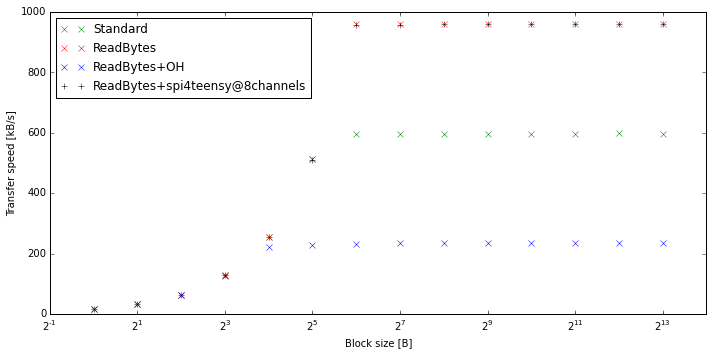

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

axes.semilogx(sizes, speeds_standard, 'gx', basex=2, label='Standard')
axes.semilogx(sizes, speeds_readbytes, 'rx', basex=2, label='ReadBytes')
axes.semilogx(sizes, speeds_readbytes_oh, 'bx', basex=2, label='ReadBytes+OH')
axes.semilogx(sizes, speeds_readbytes_spi, 'k+', basex=2, label='ReadBytes+spi4teensy@8channels')
axes.set_xlabel('Block size [B]')
axes.set_ylabel('Transfer speed [kB/s]')
axes.legend(loc=2)
axes.set_xlim((min(sizes)/2., max(sizes)*2))

fig.tight_layout()
#TODO: use individual values, make stats + error bars

In [55]:
import serial

def transfer_test(data, dev='/dev/ttyACM0'):
    """Send numpy array over serial"""
    with serial.Serial(dev) as ser:
        print "Sending {:.1f} KB".format(data.nbytes/1000.)
        return ser.write(data)

In [12]:
ser = serial.Serial('/dev/ttyACM0')
assert ser.writable()
n = int(1e6)
elapsed = %timeit -o -q transfer_test(ser, data=''.join([chr(i%256) for i in range(n)]))
print "Transferred {} KB/s".format(n/1000./mean(elapsed.all_runs))
ser.close()

Transferred 306.605353289 KB/s


### Send arbitrary signals

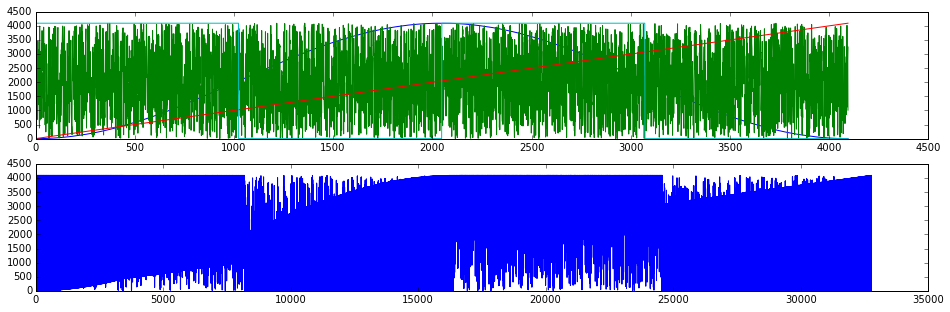

In [107]:
n_val = 4096
max_val = 4096
# cosines
cosines = ((np.cos(np.linspace(-np.pi, np.pi, num=n_val))+1)*(max_val/2)).astype('uint16')

# noise
noise = (np.random.rand(n_val)*max_val).astype('uint16')

# ramps
ramps = np.linspace(0, max_val, n_val).astype('uint16')

# squares
hi = np.ones(n_val/4, dtype='uint16')*max_val-1
lo = np.zeros_like(hi)
squares = np.tile(np.hstack((hi, lo)), 2)

# all together
arr = np.dstack((cosines, noise, ramps, squares, \
                 cosines, noise, ramps, squares)).flatten()
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 5))
axes[0].plot(cosines);
axes[0].plot(noise);
axes[0].plot(ramps);
axes[0].plot(squares);

axes[1].plot(arr);

In [108]:
n=100

In [109]:
%timeit -o -q -n 1
transfer_test(np.tile(arr, n))

Sending 6553.6 KB


3276800

In [110]:
res = _

In [111]:
t = mean(res.all_runs)
print "{:.1f} KB, {:.2f} s, {:.1f} KB/s".format(arr.nbytes/1000.*n, t, arr.nbytes/1000.*n/t)

AttributeError: 'int' object has no attribute 'all_runs'

### Send "neural" data

Read in Lynn's data set

In [112]:
data_path = "../data/lynn/lynn.dat"
data_raw = np.fromfile(data_path, dtype='(64,)i2')

In [113]:
data_float = data_raw.astype(np.float)

In [114]:
# normalize the array to 12bit
data_float -= data_float.min()
data_float /= data_float.max()
data_float *= (2**12-1)
data_scaled = data_float.astype(np.uint16)
print data_scaled.min(), data_scaled.max()

0 4095


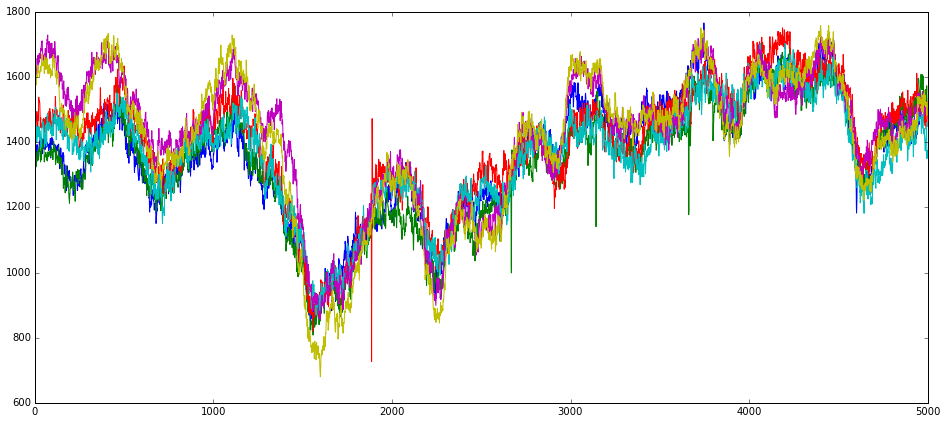

In [123]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))
axes.plot(data_scaled[0:5000, 1]);
axes.plot(data_scaled[0:5000, 12]);
axes.plot(data_scaled[0:5000, 18]);
axes.plot(data_scaled[0:5000, 23]);
axes.plot(data_scaled[0:5000, 36]);
axes.plot(data_scaled[0:5000, 55]);

In [116]:
print "first channel :", data_scaled[0,0:3]
print "second channel:", data_scaled[1,0:3]
print "interleaved   :", data_scaled[0:2,0:3].transpose().flatten()

first channel : [1367 1339 1391]
second channel: [1380 1346 1390]
interleaved   : [1367 1380 1339 1346 1391 1390]


In [ ]:
t = %timeit -q -o transfer_test(np.tile(data_scaled[:, 0:32].transpose().flatten(), 10));
mean(t.all_runs)

In [138]:
data_scaled[:, 0:32].shape

(216000, 32)